In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
import numpy as np
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.cluster import DBSCAN
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType, BooleanType, IntegerType, DoubleType, NumericType


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
spark = SparkSession.builder.appName("DBScan").getOrCreate()

In [5]:
df = spark.read.csv("/content/drive/MyDrive/Base.csv", header=True, inferSchema=True)

In [6]:
df.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+--------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_month

In [7]:
from pyspark.sql.functions import col, count

categorical_cols = ["payment_type", "employment_status", "email_is_free", "housing_status", "device_os", "source"]

# Calcolare la variabilità
variability = {}
for col_name in categorical_cols:
    counts = df.groupBy(col_name).agg(count("*").alias("count")).orderBy("count", ascending=False)
    variability[col_name] = counts

# Mostrare i risultati per ciascuna variabile categorica
for col_name, counts in variability.items():
    print(f"Variabilità per '{col_name}':")
    counts.show()

Variabilità per 'payment_type':
+------------+------+
|payment_type| count|
+------------+------+
|          AB|370554|
|          AA|258249|
|          AC|252071|
|          AD|118837|
|          AE|   289|
+------------+------+

Variabilità per 'employment_status':
+-----------------+------+
|employment_status| count|
+-----------------+------+
|               CA|730252|
|               CB|138288|
|               CF| 44034|
|               CC| 37758|
|               CD| 26522|
|               CE| 22693|
|               CG|   453|
+-----------------+------+

Variabilità per 'email_is_free':
+-------------+------+
|email_is_free| count|
+-------------+------+
|            1|529886|
|            0|470114|
+-------------+------+

Variabilità per 'housing_status':
+--------------+------+
|housing_status| count|
+--------------+------+
|            BC|372143|
|            BB|260965|
|            BA|169675|
|            BE|169135|
|            BD| 26161|
|            BF|  1669|
|           

In [8]:
df1= df.drop("source")

In [9]:
df1.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_months_count|h

In [10]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

# Lista delle variabili categoriche
categorical_cols = ["payment_type", "employment_status", "email_is_free", "housing_status", "device_os"]

# Indexing e One-Hot Encoding
stages = []
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    encoder = OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec")
    stages += [indexer, encoder]

pipeline = Pipeline(stages=stages)
model = pipeline.fit(df1)
df_encoded = model.transform(df1)

# Mostrare solo le colonne codificate
df_encoded.select([f"{col}_vec" for col in categorical_cols]).show()


+----------------+---------------------+-----------------+------------------+-------------+
|payment_type_vec|employment_status_vec|email_is_free_vec|housing_status_vec|device_os_vec|
+----------------+---------------------+-----------------+------------------+-------------+
|   (4,[1],[1.0])|        (6,[1],[1.0])|    (1,[0],[1.0])|     (6,[0],[1.0])|(4,[1],[1.0])|
|   (4,[3],[1.0])|        (6,[0],[1.0])|    (1,[0],[1.0])|     (6,[0],[1.0])|(4,[0],[1.0])|
|   (4,[0],[1.0])|        (6,[0],[1.0])|    (1,[0],[1.0])|     (6,[0],[1.0])|(4,[2],[1.0])|
|   (4,[0],[1.0])|        (6,[0],[1.0])|    (1,[0],[1.0])|     (6,[0],[1.0])|(4,[1],[1.0])|
|   (4,[1],[1.0])|        (6,[0],[1.0])|        (1,[],[])|     (6,[0],[1.0])|(4,[0],[1.0])|
|   (4,[3],[1.0])|        (6,[1],[1.0])|    (1,[0],[1.0])|     (6,[3],[1.0])|(4,[1],[1.0])|
|   (4,[0],[1.0])|        (6,[0],[1.0])|    (1,[0],[1.0])|     (6,[0],[1.0])|    (4,[],[])|
|   (4,[0],[1.0])|        (6,[0],[1.0])|        (1,[],[])|     (6,[3],[1.0])|(4,

In [11]:
df_encoded.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+-------------------------+---------+------------------+-------------------------+------------------+-----+------------------+----------------+-----------------------+---------------------+-------------------+-----------------+--------------------+------------------+---------------+-------------+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|   

In [12]:
# Elenco delle colonne puramente categoriche da rimuovere
categorical_columns = ["payment_type", "employment_status", "email_is_free", "housing_status", "device_os"]

# Eliminare le colonne categoriche
df_no_categorical = df_encoded.drop(*categorical_columns)

# Mostrare lo schema per confermare che le colonne sono state rimosse
df_no_categorical.printSchema()

# Mostrare un'anteprima del DataFrame aggiornato
df_no_categorical.show()


root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: integer (nullable = true)
 |-- current_address_months_count: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- zip_count_4w: integer (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: integer (nullable = true)
 |-- date_of_birth_distinct_emails_4w: integer (nullable = true)
 |-- credit_risk_score: integer (nullable = true)
 |-- phone_home_valid: integer (nullable = true)
 |-- phone_mobile_valid: integer (nullable = true)
 |-- bank_months_count: integer (nullable = true)
 |-- has_other_cards: integer (nullable = true)
 |-- proposed_credit_limit: double (nullable = true)

In [13]:
#Explicitly filter columns that are IntegerType or DoubleType
numerical_features = [
    col for col in df_no_categorical.columns
    if isinstance(df_no_categorical.schema[col].dataType, (IntegerType, DoubleType))
]

print("Numerical Features:")
print(numerical_features)

Numerical Features:
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'payment_type_index', 'employment_status_index', 'email_is_free_index', 'housing_status_index', 'device_os_index']


In [14]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

# Supponiamo che tu abbia una Spark session
spark = SparkSession.builder.appName("ScalingExample").getOrCreate()

# Supponiamo di avere un DataFrame Spark chiamato df_no_categorical con tutte le feature numeriche
feature_cols = [col for col, dtype in df_no_categorical.dtypes if dtype in ('int', 'double')]

# Step 1: Crea un VectorAssembler per combinare tutte le feature in una colonna vettoriale
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
df_transformed = assembler.transform(df_no_categorical)

# Step 2: Applica StandardScaler per scalare le feature
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features_vector", withMean=True, withStd=True)
scaler_model = scaler.fit(df_transformed)
df_transformed = scaler_model.transform(df_transformed)

# Step 3: Usa vector_to_array per convertire il vettore scalato in un array
df_transformed = df_transformed.withColumn("scaled_features_array", vector_to_array(col("scaled_features_vector")))

# Step 4: Estrai le singole colonne dall'array scalato e sovrascrivi le colonne originali
for i, feature in enumerate(feature_cols):
    df_transformed = df_transformed.withColumn(feature, col("scaled_features_array")[i])

# Rimuovi le colonne vettoriali non necessarie
df_transformed = df_transformed.drop("features_vector", "scaled_features_vector", "scaled_features_array")

# Mostra il DataFrame con le feature scalate
df_transformed.show()


+--------------------+--------------------+---------------------+-------------------------+----------------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------------------+--------------------+-------------------+------------------+--------------------+-------------------+---------------------+-------------------+-------------------------+------------------+-------------------------+------------------+------------------+--------------------+----------------+-----------------------+---------------------+-------------------+-----------------+--------------------+------------------+--------------------+-------------+
|          fraud_bool|              income|name_email_similarity|prev_address_months_count|current_address_months_count|        customer_age|  days_since_request|intended_balcon_amount|        zip_count_4w|         velocity_6h|  

In [27]:
df_transformed.write.parquet("/content/drive/MyDrive/ProgettoDDAM/ds_clustering.parquet")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [17]:
df_transformed= df_transformed.drop('fraud_bool')
feature_cols = [col for col, dtype in df_transformed.dtypes if dtype in ('int', 'double')]
print(f"Selected feature columns: {feature_cols}")


Selected feature columns: ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'payment_type_index', 'employment_status_index', 'email_is_free_index', 'housing_status_index', 'device_os_index']


In [28]:
df_transformed.show()

+--------------------+---------------------+-------------------------+----------------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------------------+--------------------+-------------------+------------------+--------------------+-------------------+---------------------+-------------------+-------------------------+------------------+-------------------------+------------------+------------------+--------------------+----------------+-----------------------+---------------------+-------------------+-----------------+--------------------+------------------+--------------------+-------------+
|              income|name_email_similarity|prev_address_months_count|current_address_months_count|        customer_age|  days_since_request|intended_balcon_amount|        zip_count_4w|         velocity_6h|        velocity_24h|       velocity_4w|bank

**KMEANS**

In [18]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
vectorized_data = assembler.transform(df_transformed).select("features")
vectorized_data.show(5)

+--------------------+
|            features|
+--------------------+
|[-0.9047780069624...|
|[0.81732545986853...|
|[0.81732545986853...|
|[0.12848407313613...|
|[1.16174615323473...|
+--------------------+
only showing top 5 rows



K: 2, Silhouette Score: 0.1303650864195752, SSE: 26935005.340956643
K: 3, Silhouette Score: 0.11142872025205454, SSE: 25967698.629233494
K: 4, Silhouette Score: 0.10487764873418122, SSE: 25353169.96498722
K: 5, Silhouette Score: 0.08761112416940325, SSE: 24821615.40203262
K: 6, Silhouette Score: 0.10463963084165354, SSE: 23831091.90716245
K: 7, Silhouette Score: 0.11770400148963864, SSE: 23283348.001493953
K: 8, Silhouette Score: 0.09028301419546807, SSE: 22962562.069111124
K: 9, Silhouette Score: 0.07053877946117126, SSE: 22993112.473132312
K: 10, Silhouette Score: 0.07519300892138071, SSE: 22090954.36051575
K: 11, Silhouette Score: 0.1252914965521771, SSE: 21159155.212145224
K: 12, Silhouette Score: 0.09565782571060259, SSE: 21300072.599664673
K: 13, Silhouette Score: 0.1064775291117779, SSE: 20582361.90843652
K: 14, Silhouette Score: 0.09518360759192246, SSE: 20575227.316181965
K: 15, Silhouette Score: 0.09151172671706748, SSE: 20317586.04348903
K: 16, Silhouette Score: 0.0840693352

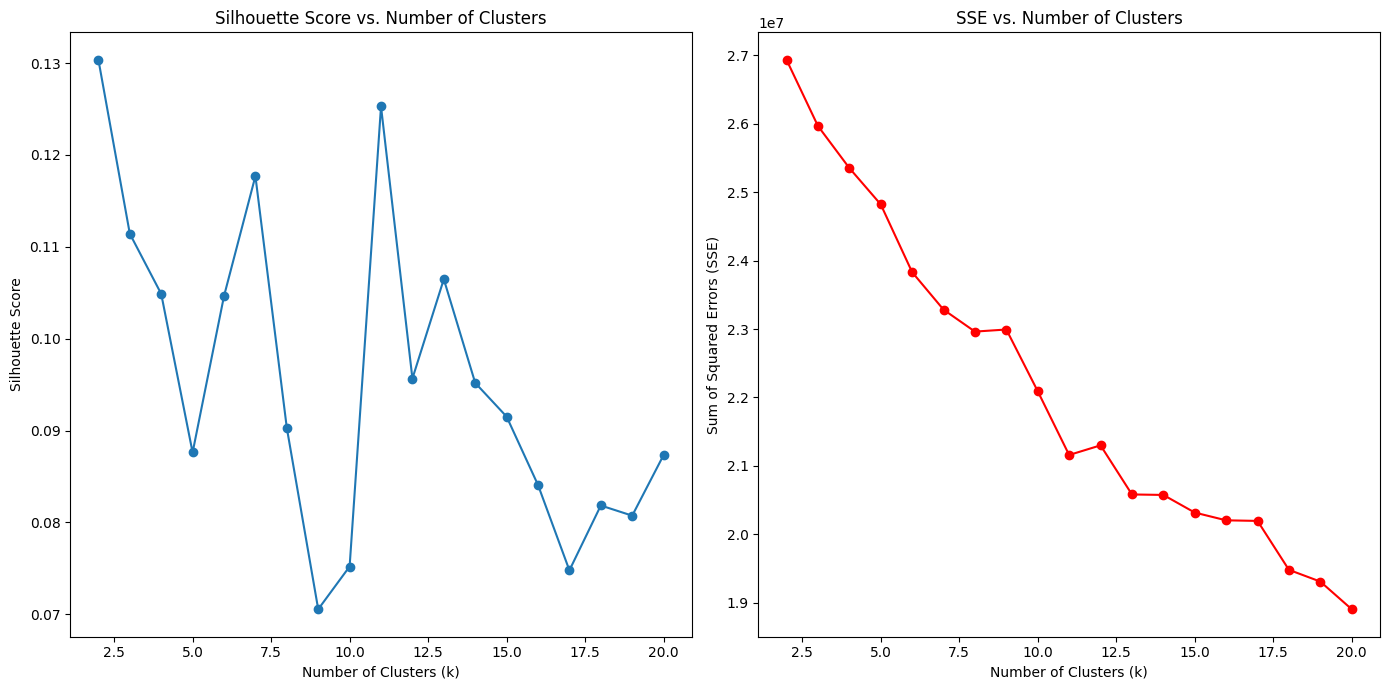

In [30]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Initialize lists to store metrics
silhouette_scores = []
sse_values = []
k_values = range(2, 21)  # Start from 2 clusters, as Silhouette is not defined for k=1

# Loop through different values of k
for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(vectorized_data)

    # Make predictions
    predictions = model.transform(vectorized_data)

    # Calculate Silhouette Score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)

    # Calculate SSE (Sum of Squared Errors)
    sse = model.summary.trainingCost
    sse_values.append(sse)

    print(f"K: {k}, Silhouette Score: {silhouette}, SSE: {sse}")

# Plot the metrics
plt.figure(figsize=(14, 7))

# Plot Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

# Plot SSE
plt.subplot(1, 2, 2)
plt.plot(k_values, sse_values, marker='o', color='red')
plt.title("SSE vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")

plt.tight_layout()
plt.show()


**6 cluster**

In [19]:
kmeans = KMeans().setK(11).setSeed(1)
model_km = kmeans.fit(vectorized_data)

# Evaluate the model
predictions_km = model_km.transform(vectorized_data)
evaluator_km = ClusteringEvaluator()
silhouette_km = evaluator_km.evaluate(predictions_km)

print(f"Silhouette Score: {silhouette_km}")

# Show predictions
predictions_km.show(5)

Silhouette Score: 0.1252914965521771
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-0.9047780069624...|         8|
|[0.81732545986853...|         1|
|[0.81732545986853...|         1|
|[0.12848407313613...|         1|
|[1.16174615323473...|         8|
+--------------------+----------+
only showing top 5 rows



In [20]:
from pyspark.sql.functions import col

# Group by the prediction (cluster label) and count the number of records in each cluster
cluster_counts = predictions_km.groupBy("prediction").count()

# Show the cluster counts
cluster_counts.show()


+----------+------+
|prediction| count|
+----------+------+
|         1|213467|
|         6|128301|
|         3| 69364|
|         5|115499|
|         9| 99449|
|         4| 26198|
|         8| 69434|
|         7|225477|
|        10| 24988|
|         2| 24090|
|         0|  3733|
+----------+------+



<ipython-input-40-17889fbfb648>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 11)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


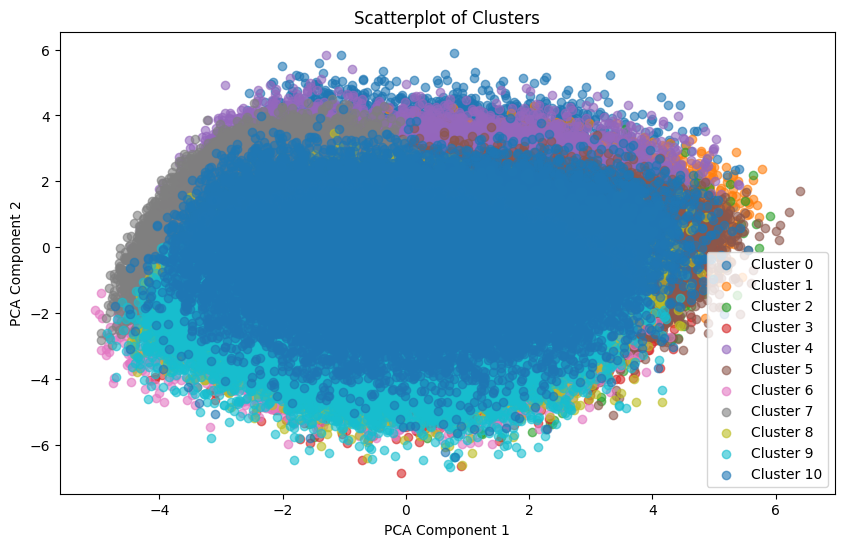

In [40]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col

# Apply PCA to reduce dimensions to 2
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(vectorized_data)
pca_result = pca_model.transform(predictions_km)
# Convert the PCA-transformed data and cluster predictions to Pandas for visualization
pandas_df = pca_result.select("pca_features", "prediction").toPandas()
import matplotlib.pyplot as plt

# Configure the visualization
plt.figure(figsize=(10, 6))

# Use a colormap for distinguishing clusters
colors = plt.cm.get_cmap('tab20', 11)

# Plot each cluster
for cluster_id in range(11):  # Assuming k=6
    cluster_data = pandas_df[pandas_df['prediction'] == cluster_id]
    plt.scatter(
        cluster_data['pca_features'].apply(lambda x: x[0]),
        cluster_data['pca_features'].apply(lambda x: x[1]),
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )

# Configure axes, legend, and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatterplot of Clusters')
plt.legend()
plt.show()


In [24]:
# Get the PCA loadings matrix
pca_components = pca_model.pc.toArray()

# Print the components
print("PCA Components (Loadings):")
for i, component in enumerate(pca_components):
    print(f"Principal Component {i + 1}: {component}")


PCA Components (Loadings):
Principal Component 1: [-0.1439375  -0.07293837]
Principal Component 2: [ 0.0308115  -0.06402097]
Principal Component 3: [0.0248735  0.21571376]
Principal Component 4: [-0.03172719 -0.38880437]
Principal Component 5: [-0.10933425 -0.37838   ]
Principal Component 6: [0.04529106 0.12437436]
Principal Component 7: [ 0.03085841 -0.12723013]
Principal Component 8: [ 0.24256016 -0.07688265]
Principal Component 9: [ 0.34808951 -0.1120108 ]
Principal Component 10: [ 0.4125851  -0.14503424]
Principal Component 11: [ 0.48036016 -0.16265412]
Principal Component 12: [ 0.01341555 -0.14150772]
Principal Component 13: [0.23976504 0.26670132]
Principal Component 14: [-0.22353492 -0.28654019]
Principal Component 15: [-0.09240217 -0.25020825]
Principal Component 16: [0.01092045 0.19944416]
Principal Component 17: [ 0.02297051 -0.13308772]
Principal Component 18: [-0.08061342 -0.18877389]
Principal Component 19: [-0.07435877 -0.35439667]
Principal Component 20: [ 0.01567345 -0.

In [26]:
centroids_km = model_km.clusterCenters()
for idx_km, centroid_km in enumerate(centroids_km):
    print(f"Cluster {idx_km} centroid: {centroid_km} ")

Cluster 0 centroid: [-2.34743737e-02 -8.39237395e-02  6.31788676e-01 -5.20039857e-01
 -2.39491719e-01  1.29143107e+01 -2.23108566e-01 -1.26596699e-01
  4.55523122e-04 -5.93122313e-02 -9.79376433e-02 -2.44937842e-01
  1.44390894e-01 -2.98210443e-01 -2.81937139e-01 -9.92290867e-04
 -5.00397322e-01 -2.75065508e-01 -3.28440521e-01  5.25510967e-02
  2.37655021e-01  5.56148033e-03  7.94942123e-02  0.00000000e+00
  1.23077728e-01  5.03232185e-01 -8.64727645e-02  6.01473912e-02
 -2.49698519e-01  2.47649952e-02] 
Cluster 1 centroid: [-0.16075997 -0.03352197  0.01713572 -0.54740998 -0.24961034  0.0399734
 -0.25992415  0.24825828  0.42657188  0.49613675  0.61184854 -0.28080806
  0.51971162 -0.49856423 -0.34691446  0.26692348 -0.18810834 -0.19466145
 -0.42759826 -0.1609212   0.13433269  0.11186147 -0.14543814  0.
 -0.64415482  0.19111035 -0.04972319 -0.20727928 -0.69167349 -0.0476503 ] 
Cluster 2 centroid: [-0.10949361 -0.13366313 -0.02993129  0.04213676  0.27055457  0.02779549
 -0.19252503  0.165

**DB SCAN**

In [29]:
import pandas as pd
import numpy as np
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN

DBSCAN_HYPERPARAMETERS = None  # O, ad esempio: (0.5, 5)

@pandas_udf(returnType=IntegerType())
def run_dbscan_pandas(*cols: pd.Series) -> pd.Series:
    # Combina le colonne in un array NumPy
    values = np.column_stack([col.to_numpy() for col in cols])

    # Calcola i parametri di DBSCAN
    if DBSCAN_HYPERPARAMETERS is None:
        # Usa una stima automatica per `eps`
        distances = np.linalg.norm(values - np.mean(values, axis=0), axis=1)
        epsilon = np.percentile(distances, 90)  # 90° percentile
        minimumSamples = 2
    else:
        epsilon, minimumSamples = DBSCAN_HYPERPARAMETERS

    # Applica DBSCAN
    dbModel = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(values)

    # Restituisce le etichette
    return pd.Series(dbModel.labels_)

# Seleziona le colonne delle feature
feature_cols = [col for col, dtype in df_transformed.dtypes if dtype in ('int', 'double')]

# Applica la funzione DBSCAN
df_with_clusters = df_transformed.withColumn(
    'cluster',
    run_dbscan_pandas(*[F.col(c) for c in feature_cols])
)

# Mostra il risultato
df_with_clusters.show()


+--------------------+---------------------+-------------------------+----------------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------------------+--------------------+-------------------+------------------+--------------------+-------------------+---------------------+-------------------+-------------------------+------------------+-------------------------+------------------+------------------+--------------------+----------------+-----------------------+---------------------+-------------------+-----------------+--------------------+------------------+--------------------+-------------+-------+
|              income|name_email_similarity|prev_address_months_count|current_address_months_count|        customer_age|  days_since_request|intended_balcon_amount|        zip_count_4w|         velocity_6h|        velocity_24h|       velocity

In [30]:
# Calcola la frequenza di ogni cluster
cluster_distribution = df_with_clusters.groupBy('cluster').count()

# Mostra la distribuzione
cluster_distribution.show()

+-------+------+
|cluster| count|
+-------+------+
|     -1|  1053|
|      1|  9562|
|      3|   182|
|      4|    61|
|      2|  3104|
|      0|986012|
|      6|     2|
|      5|    24|
+-------+------+



<ipython-input-33-883179d413f9>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', predictions_km.select("prediction").distinct().count())  # Automatically adapt to the number of clusters
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


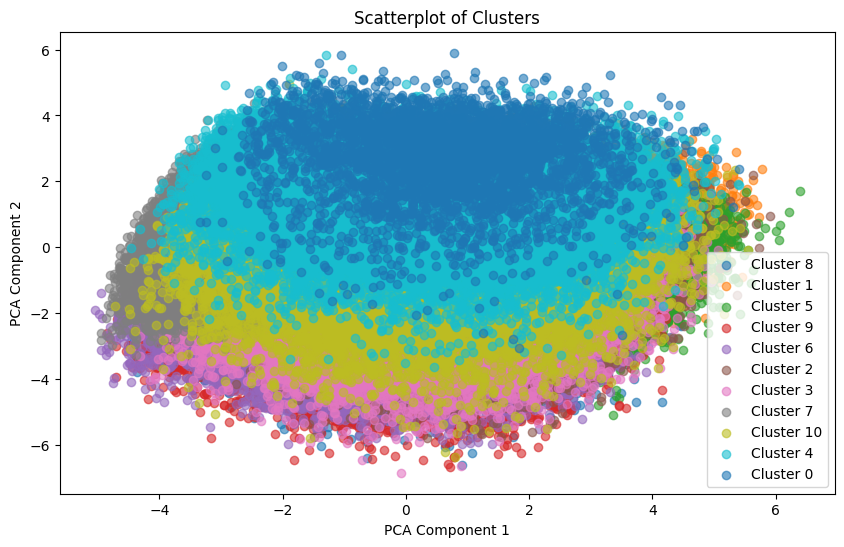

In [33]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensions to 2
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(vectorized_data)  # `vectorized_data` contains your "features" column
pca_result = pca_model.transform(predictions_km)  # `predictions_km` contains your cluster predictions

# Convert the PCA-transformed data and cluster predictions to Pandas for visualization
pandas_df = pca_result.select("pca_features", "prediction").toPandas()

# Configure the visualization
plt.figure(figsize=(10, 6))

# Use a colormap for distinguishing clusters
colors = plt.cm.get_cmap('tab20', predictions_km.select("prediction").distinct().count())  # Automatically adapt to the number of clusters

# Plot each cluster
for cluster_id in pandas_df['prediction'].unique():
    cluster_data = pandas_df[pandas_df['prediction'] == cluster_id]
    plt.scatter(
        cluster_data['pca_features'].apply(lambda x: x[0]),
        cluster_data['pca_features'].apply(lambda x: x[1]),
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )

# Configure axes, legend, and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatterplot of Clusters')
plt.legend()
plt.show()


In [36]:
# Get the PCA loadings matrix
pca_components = pca_model.pc.toArray()

# Print the components
print("PCA Components (Loadings):")
for i, component in enumerate(pca_components):
    print(f"Principal Component {i + 1}: {component}")

# Optionally, create a DataFrame to better analyze the contributions of each feature
feature_contributions = pd.DataFrame(
    pca_components,
    columns=feature_cols,  # `feature_cols` contains your original feature names
    index=[f"Principal Component {i+1}" for i in range(pca_components.shape[0])]
)

# Show the contributions
print("Feature Contributions to Principal Components:")
print(feature_contributions)


PCA Components (Loadings):
Principal Component 1: [-0.1439375  -0.07293837]
Principal Component 2: [ 0.0308115  -0.06402097]
Principal Component 3: [0.0248735  0.21571376]
Principal Component 4: [-0.03172719 -0.38880437]
Principal Component 5: [-0.10933425 -0.37838   ]
Principal Component 6: [0.04529106 0.12437436]
Principal Component 7: [ 0.03085841 -0.12723013]
Principal Component 8: [ 0.24256016 -0.07688265]
Principal Component 9: [ 0.34808951 -0.1120108 ]
Principal Component 10: [ 0.4125851  -0.14503424]
Principal Component 11: [ 0.48036016 -0.16265412]
Principal Component 12: [ 0.01341555 -0.14150772]
Principal Component 13: [0.23976504 0.26670132]
Principal Component 14: [-0.22353492 -0.28654019]
Principal Component 15: [-0.09240217 -0.25020825]
Principal Component 16: [0.01092045 0.19944416]
Principal Component 17: [ 0.02297051 -0.13308772]
Principal Component 18: [-0.08061342 -0.18877389]
Principal Component 19: [-0.07435877 -0.35439667]
Principal Component 20: [ 0.01567345 -0.

ValueError: Shape of passed values is (30, 2), indices imply (30, 35)

In [42]:
df_noise = df_with_clusters.filter(F.col("cluster") == -1)
df_noise.show()

+-------------------+---------------------+-------------------------+----------------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------------------+--------------------+-------------------+------------------+--------------------+-------------------+---------------------+-------------------+-------------------------+------------------+-------------------------+------------------+------------------+--------------------+----------------+-----------------------+---------------------+-------------------+-----------------+--------------------+------------------+--------------------+-------------+-------+
|             income|name_email_similarity|prev_address_months_count|current_address_months_count|        customer_age|  days_since_request|intended_balcon_amount|        zip_count_4w|         velocity_6h|        velocity_24h|        velocity

**BISECTING KMEANS**

In [37]:
from pyspark.ml.feature import VectorAssembler

# Creazione del VectorAssembler
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Trasforma il DataFrame
df_transformed = vector_assembler.transform(df_transformed)



In [41]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores = []
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette")

for K in range(2, 11):
    # Inizializza BisectingKMeans
    BKMeans_ = BisectingKMeans(featuresCol="features", k=K, minDivisibleClusterSize=1)

    # Esegui il fit del modello
    BKMeans_fit = BKMeans_.fit(df_transformed)

    # Trasforma il DataFrame
    BKMeans_transform = BKMeans_fit.transform(df_transformed)

    # Calcola il Silhouette Score
    evaluation_score = evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)


Text(0, 0.5, 'Silhouette Score')

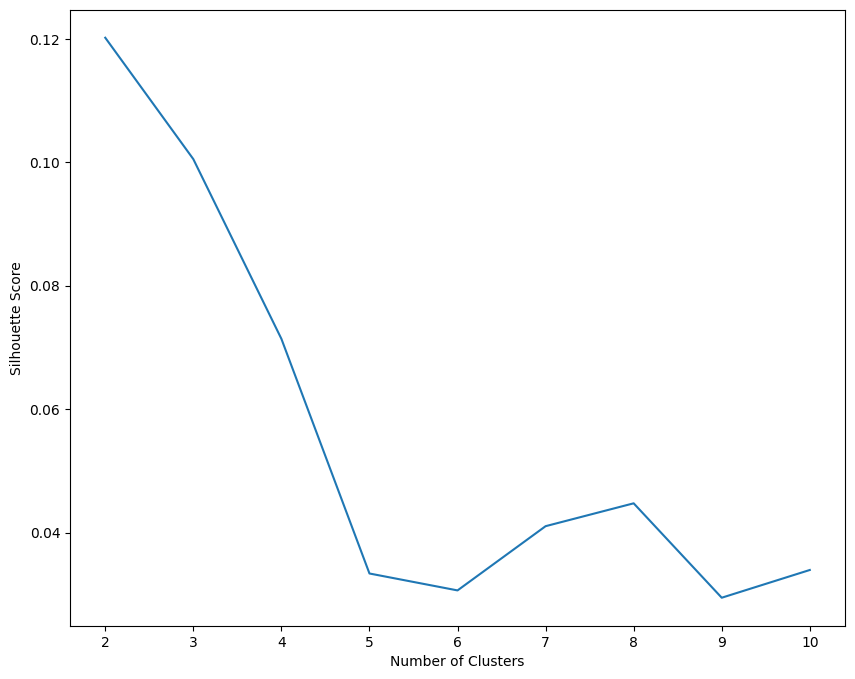

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [ ]:
BKMeans_=BisectingKMeans(featuresCol="features", k=4)
BKMeans_Model=BKMeans_.fit(df_transformed)
BKMeans_transform=BKMeans_Model.transform(df_transformed)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


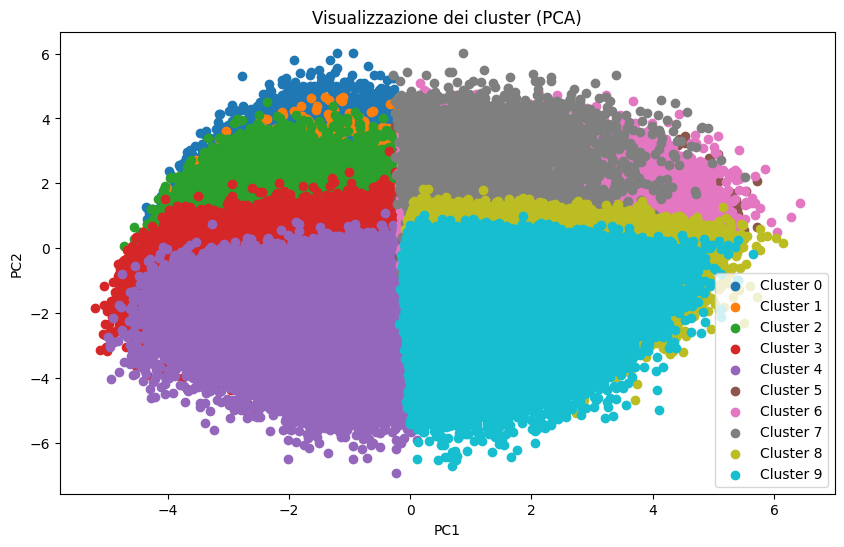

In [44]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Applica PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(BKMeans_transform)
df_pca = pca_model.transform(BKMeans_transform)

# Converte in Pandas per visualizzare
df_pandas = df_pca.select("pca_features", "prediction").toPandas()
pca_features = df_pandas["pca_features"].apply(lambda x: x.toArray())
pca_df = pd.DataFrame(pca_features.tolist(), columns=["PC1", "PC2"])
pca_df["Cluster"] = df_pandas["prediction"]

# Plot
plt.figure(figsize=(10, 6))
for cluster_id in sorted(pca_df["Cluster"].unique()):
    cluster_data = pca_df[pca_df["Cluster"] == cluster_id]
    plt.scatter(cluster_data["PC1"], cluster_data["PC2"], label=f"Cluster {cluster_id}")
plt.legend()
plt.title("Visualizzazione dei cluster (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [45]:
BKMeans_transform.groupBy("prediction").count().orderBy("prediction").show()

+----------+------+
|prediction| count|
+----------+------+
|         0|109461|
|         1| 58625|
|         2|140727|
|         3|112608|
|         4| 73612|
|         5|131619|
|         6|147297|
|         7|  3066|
|         8|103618|
|         9|119367|
+----------+------+



In [46]:
cluster_profiles = BKMeans_transform.groupBy("prediction").agg(
    *[F.mean(col).alias(f"{col}_mean") for col in feature_cols],
    *[F.stddev(col).alias(f"{col}_std") for col in feature_cols]
)
cluster_profiles.show()

AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "avg(payment_type_vec)" due to data type mismatch: Parameter 1 requires the "NUMERIC" or "ANSI INTERVAL" type, however "payment_type_vec" has the type "STRUCT<type: TINYINT, size: INT, indices: ARRAY<INT>, values: ARRAY<DOUBLE>>".;
'Aggregate [prediction#9769], [prediction#9769, avg(income#2414) AS income_mean#10193, avg(name_email_similarity#2454) AS name_email_similarity_mean#10195, avg(prev_address_months_count#2494) AS prev_address_months_count_mean#10197, avg(current_address_months_count#2534) AS current_address_months_count_mean#10199, avg(customer_age#2574) AS customer_age_mean#10201, avg(days_since_request#2614) AS days_since_request_mean#10203, avg(intended_balcon_amount#2654) AS intended_balcon_amount_mean#10205, avg(zip_count_4w#2694) AS zip_count_4w_mean#10207, avg(velocity_6h#2734) AS velocity_6h_mean#10209, avg(velocity_24h#2774) AS velocity_24h_mean#10211, avg(velocity_4w#2814) AS velocity_4w_mean#10213, avg(bank_branch_count_8w#2854) AS bank_branch_count_8w_mean#10215, avg(date_of_birth_distinct_emails_4w#2894) AS date_of_birth_distinct_emails_4w_mean#10217, avg(credit_risk_score#2934) AS credit_risk_score_mean#10219, avg(phone_home_valid#2974) AS phone_home_valid_mean#10221, avg(phone_mobile_valid#3014) AS phone_mobile_valid_mean#10223, avg(bank_months_count#3054) AS bank_months_count_mean#10225, avg(has_other_cards#3094) AS has_other_cards_mean#10227, avg(proposed_credit_limit#3134) AS proposed_credit_limit_mean#10229, avg(foreign_request#3174) AS foreign_request_mean#10231, avg(session_length_in_minutes#3214) AS session_length_in_minutes_mean#10233, avg(keep_alive_session#3254) AS keep_alive_session_mean#10235, avg(device_distinct_emails_8w#3294) AS device_distinct_emails_8w_mean#10237, ... 47 more fields]
+- Project [income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, device_fraud_count#3334, ... 13 more fields]
   +- Project [income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, device_fraud_count#3334, ... 12 more fields]
      +- Project [income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, device_fraud_count#3334, ... 11 more fields]
         +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, ... 12 more fields]
            +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, ... 15 more fields]
               +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, ... 15 more fields]
                  +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, ... 15 more fields]
                     +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, ... 15 more fields]
                        +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, ... 15 more fields]
                           +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, ... 15 more fields]
                              +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, device_distinct_emails_8w#3294, ... 15 more fields]
                                 +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, keep_alive_session#3254, scaled_features_array#2334[23] AS device_distinct_emails_8w#3294, ... 15 more fields]
                                    +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, session_length_in_minutes#3214, scaled_features_array#2334[22] AS keep_alive_session#3254, device_distinct_emails_8w#46, ... 15 more fields]
                                       +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, foreign_request#3174, scaled_features_array#2334[21] AS session_length_in_minutes#3214, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                          +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, proposed_credit_limit#3134, scaled_features_array#2334[20] AS foreign_request#3174, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                             +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, has_other_cards#3094, scaled_features_array#2334[19] AS proposed_credit_limit#3134, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, bank_months_count#3054, scaled_features_array#2334[18] AS has_other_cards#3094, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                   +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, phone_mobile_valid#3014, scaled_features_array#2334[17] AS bank_months_count#3054, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                      +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, phone_home_valid#2974, scaled_features_array#2334[16] AS phone_mobile_valid#3014, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                         +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, credit_risk_score#2934, scaled_features_array#2334[15] AS phone_home_valid#2974, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                            +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#2894, scaled_features_array#2334[14] AS credit_risk_score#2934, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                               +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, bank_branch_count_8w#2854, scaled_features_array#2334[13] AS date_of_birth_distinct_emails_4w#2894, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                  +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, velocity_4w#2814, scaled_features_array#2334[12] AS bank_branch_count_8w#2854, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                     +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, velocity_24h#2774, scaled_features_array#2334[11] AS velocity_4w#2814, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                        +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, velocity_6h#2734, scaled_features_array#2334[10] AS velocity_24h#2774, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                           +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, zip_count_4w#2694, scaled_features_array#2334[9] AS velocity_6h#2734, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                              +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, intended_balcon_amount#2654, scaled_features_array#2334[8] AS zip_count_4w#2694, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                 +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, days_since_request#2614, scaled_features_array#2334[7] AS intended_balcon_amount#2654, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                    +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, customer_age#2574, scaled_features_array#2334[6] AS days_since_request#2614, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                       +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, current_address_months_count#2534, scaled_features_array#2334[5] AS customer_age#2574, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                          +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, prev_address_months_count#2494, scaled_features_array#2334[4] AS current_address_months_count#2534, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                             +- Project [fraud_bool#2374, income#2414, name_email_similarity#2454, scaled_features_array#2334[3] AS prev_address_months_count#2494, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                                +- Project [fraud_bool#2374, income#2414, scaled_features_array#2334[2] AS name_email_similarity#2454, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                                   +- Project [fraud_bool#2374, scaled_features_array#2334[1] AS income#2414, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                                      +- Project [scaled_features_array#2334[0] AS fraud_bool#2374, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                                         +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 15 more fields]
                                                                                                            +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 14 more fields]
                                                                                                               +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 13 more fields]
                                                                                                                  +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, credit_risk_score#33, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, foreign_request#41, session_length_in_minutes#43, keep_alive_session#45, device_distinct_emails_8w#46, ... 12 more fields]
                                                                                                                     +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 17 more fields]
                                                                                                                        +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 16 more fields]
                                                                                                                           +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 15 more fields]
                                                                                                                              +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 14 more fields]
                                                                                                                                 +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 13 more fields]
                                                                                                                                    +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 12 more fields]
                                                                                                                                       +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 11 more fields]
                                                                                                                                          +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 10 more fields]
                                                                                                                                             +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 9 more fields]
                                                                                                                                                +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 8 more fields]
                                                                                                                                                   +- Project [fraud_bool#17, income#18, name_email_similarity#19, prev_address_months_count#20, current_address_months_count#21, customer_age#22, days_since_request#23, intended_balcon_amount#24, payment_type#25, zip_count_4w#26, velocity_6h#27, velocity_24h#28, velocity_4w#29, bank_branch_count_8w#30, date_of_birth_distinct_emails_4w#31, employment_status#32, credit_risk_score#33, email_is_free#34, housing_status#35, phone_home_valid#36, phone_mobile_valid#37, bank_months_count#38, has_other_cards#39, proposed_credit_limit#40, ... 7 more fields]
                                                                                                                                                      +- Relation [fraud_bool#17,income#18,name_email_similarity#19,prev_address_months_count#20,current_address_months_count#21,customer_age#22,days_since_request#23,intended_balcon_amount#24,payment_type#25,zip_count_4w#26,velocity_6h#27,velocity_24h#28,velocity_4w#29,bank_branch_count_8w#30,date_of_birth_distinct_emails_4w#31,employment_status#32,credit_risk_score#33,email_is_free#34,housing_status#35,phone_home_valid#36,phone_mobile_valid#37,bank_months_count#38,has_other_cards#39,proposed_credit_limit#40,... 8 more fields] csv
